In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json
import os
import numpy as np

In [2]:
# Tentukan direktori dataset
dataset_dir = 'C:\\Users\\N1NRK\\OneDrive\\Documents\\dataset-sampah\\dataset-sampah'
img_height, img_width = 224, 224
batch_size = 32

In [3]:
# Membuat list gambar dan label
def load_data(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            labels.append(class_name)
    return np.array(images), np.array(labels), class_names

images, labels, class_names = load_data(dataset_dir)

In [4]:
# Encode labels
label_to_index = {name: index for index, name in enumerate(class_names)}
labels = np.array([label_to_index[label] for label in labels])


In [5]:
# Split data menjadi data pelatihan dan data pengujian
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


In [6]:
# Normalisasi data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [7]:
# Membuat ImageDataGenerator untuk augmentasi data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)


In [8]:
# Menggunakan MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [9]:
# Membekukan semua lapisan kecuali lapisan terakhir
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [10]:
# Membangun model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Kompilasi model dengan learning rate scheduler
model.compile(optimizer=Adam(lr=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Callback untuk mengatur learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [11]:
# Melatih model dengan callback
epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50



175/175 [==============================] - 63s 339ms/step - loss: 0.8959 - accuracy: 0.6938 - val_loss: 3.8163 - val_accuracy: 0.5993 - lr: 0.0010
Epoch 2/50
175/175 [==============================] - 58s 330ms/step - loss: 0.5973 - accuracy: 0.7962 - val_loss: 3.6233 - val_accuracy: 0.5857 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - 59s 335ms/step - loss: 0.5239 - accuracy: 0.8295 - val_loss: 4.9403 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - 58s 332ms/step - loss: 0.4589 - accuracy: 0.8489 - val_loss: 4.3848 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - 60s 340ms/step - loss: 0.4246 - accuracy: 0.8602 - val_loss: 6.3374 - val_accuracy: 0.4636 - lr: 0.0010
Epoch 6/50
175/175 [==============================] - 60s 340ms/step - loss: 0.3451 - accuracy: 0.8893 - val_loss: 7.8778 - val_accuracy: 0.4350 - lr: 0.0010
Epoch 7/50
175/175 [==============================] - 59s 338ms

In [12]:
# Evaluasi model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

44/44 [==============================] - 7s 155ms/step - loss: 0.5555 - accuracy: 0.9029
Validation Accuracy: 90.29%


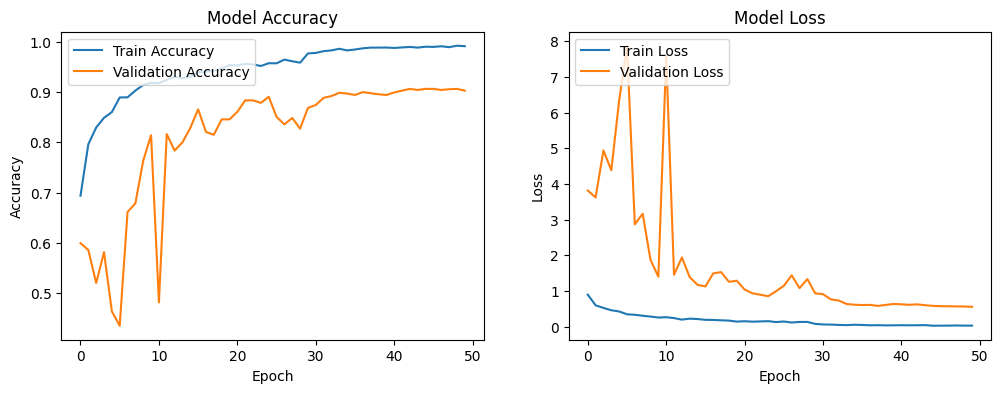

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [14]:
# Menyimpan model
model.save('trashify_model.h5')

C:\Users\N1NRK\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# Menyimpan model dalam format JSON
model_json = model.to_json()
with open("trashify_model.json", "w") as json_file:
    json_file.write(model_json)


In [16]:
# Menyimpan bobot model secara terpisah untuk menjaga ukuran file JSON tetap kecil
model.save_weights("trashify_model_weight.h5")

print("Model saved in both H5 (binary) and JSON formats")

Model saved in both H5 (binary) and JSON formats


In [17]:
# Save model using pickle (binary)
import pickle

with open('trashify_model.pkl', 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

print("Model saved in Pickle format as well")

Model saved in Pickle format as well


In [18]:
# Memuat model dari H5 (binary)
from tensorflow.keras.models import load_model
loaded_model_bin = load_model('trashify_model.h5')

In [26]:
# Memuat model dari file JSON
with open("trashify_model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model_from_json = model_from_json(loaded_model_json)
loaded_model_from_json.load_weights('trashify_model_weight.h5')
loaded_model_from_json.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Memuat model dari file Pickle
with open('trashify_model.pkl', 'rb') as pickle_file:
    loaded_model_pickle = pickle.load(pickle_file)
loaded_model_pickle.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [38]:
# Verifikasi bahwa model yang dimuat adalah sama
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os

# Memuat gambar uji untuk memverifikasi prediksi
test_image_path = os.path.join(dataset_dir, 'test3.png')  # Ganti dengan path gambar uji yang ada
test_image = load_img(test_image_path, target_size=(img_height, img_width))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0) / 255.0

In [39]:
# Daftar nama kelas sesuai dengan urutan indeks
class_names = ['botol', 'kaca', 'kardus', 'kertas', 'metal', 'organic', 'plastic']

# Memprediksi menggunakan ketiga model
pred_bin = loaded_model_bin.predict(test_image)
pred_json = loaded_model_from_json.predict(test_image)
pred_pickle = loaded_model_pickle.predict(test_image)

# Mendapatkan indeks dari kelas yang diprediksi
pred_class_bin = np.argmax(pred_bin, axis=1)
pred_class_json = np.argmax(pred_json, axis=1)
pred_class_pickle = np.argmax(pred_pickle, axis=1)

# Mencetak hasil prediksi dengan nama kelas
print(f"Prediction from binary model (H5): {pred_bin} => Predicted class: {class_names[pred_class_bin[0]]}")
print(f"Prediction from JSON model: {pred_json} => Predicted class: {class_names[pred_class_json[0]]}")
print(f"Prediction from Pickle model: {pred_pickle} => Predicted class: {class_names[pred_class_pickle[0]]}")

1/1 [==============================] - 0s 30ms/step
Prediction from binary model (H5): [[5.9638993e-04 9.9850392e-01 3.0755891e-07 8.4011026e-07 8.8779762e-04
  1.8069363e-06 9.0168032e-06]] => Predicted class: kaca
Prediction from JSON model: [[5.9638993e-04 9.9850392e-01 3.0755891e-07 8.4011026e-07 8.8779762e-04
  1.8069363e-06 9.0168032e-06]] => Predicted class: kaca
Prediction from Pickle model: [[5.9638993e-04 9.9850392e-01 3.0755891e-07 8.4011026e-07 8.8779762e-04
  1.8069363e-06 9.0168032e-06]] => Predicted class: kaca
